In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import matplotlib.pyplot as plt

import copy

import pygraphviz as pgv
import json

import pm4py

from collections import Counter
import subprocess

from sklearn import mixture

In [3]:
# global variables
SAVE_ELEMENTS = True # store generated elements

#paths
BPI_PATH = 'BPI_Challenge_2012.xes'
BPI_PATH_PROCESSED = 'bpi2012.xes'
ACTIVITIES_PATH = 'activities2012.xml'

# log processing
MIN_SPEAKING_TIME = 60
DAY_DIFFERENCE = 10
CLUSTER_COMPONENTS = 3

# verfification
VERIFYTA_PATH = "/home/paul/Downloads/uppaal-4.1.20-stratego-10-linux64/bin/verifyta"

In [4]:
# Load the log
from pm4py.objects.log.importer.xes import importer as xes_importer
log_application = xes_importer.apply(BPI_PATH)

/home/paul/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/home/paul/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 13087/13087 [00:08<00:00, 1491.38it/s]


In [5]:
# helpfer function to check if element is contained in trace
def contains(trace, element):
    for event in trace:
        if event['concept:name']==element:
            return True
    return False

# Preprocessing

In the preprocessing, we:
- transform the log into a list format
- discretise offer events
- remove trivial events
- remove incomplete and declines journeys
- compute durations of calls
- cluster call events 

In [6]:
# detect "redundant" events -> can be omitted
for trace in log_application:
    for i in range(len(trace)):
        if trace[i]['concept:name'] == "A_PARTLYSUBMITTED":
            assert(trace[i-1]['concept:name']== "A_SUBMITTED")

        """
        # cant confirm from Bautista et al.
        if trace[i]['concept:name'] == "O_CANCELLED":
            if not (trace[i+1]['concept:name'] == "A_CANCELLED" or trace[i-1]['concept:name'] == "A_CANCELLED"):
                print(trace[i-2]['concept:name'])
                print(trace[i-1]['concept:name'])
                print(trace[i]['concept:name'])
                print(trace[i+1]['concept:name'])
                print(trace[i+2]['concept:name'])
            assert(trace[i+1]['concept:name']== "A_CANCELLED" or trace[i-1]['concept:name']== "A_CANCELLED")
        """

        if trace[i]['concept:name'] == "O_DECLINED":
            assert(trace[i+1]['concept:name']== "A_DECLINED" or trace[i-1]['concept:name']== "A_DECLINED")
        
        # in successfull traces always 4 events together; occur only in successfull traces
        if contains(trace, "A_APPROVED"):
            if trace[i]['concept:name'] == "A_APPROVED":
                pos1 = 0
                pos2 = 0
                pos3 = 0

                for j in range(len(trace)):
                    if trace[j]["concept:name"] == "O_ACCEPTED":
                        pos1 = j
                for j in range(len(trace)):
                    if trace[j]["concept:name"] == "A_ACTIVATED":
                        pos2 = j
                for j in range(len(trace)):
                    if trace[j]["concept:name"] == "A_REGISTERED":
                        pos3 = j

                s = sorted([pos1, pos2, pos3, i])
                assert(s[0] == s[1]-1 and s[1] == s[2]-1 and s[2] == s[3]-1 or not contains(trace, "O_ACCEPTED") and s[1] == s[2]-1 and s[2] == s[3]-1 ) 
                # in three cases is "O_ACCEPTED" not contained, but then are the offers also pre-accepted and the other three elements are in group
        else:
            assert(not contains(trace, "A_APPROVED"))
            assert(not contains(trace, "O_ACCEPTED"))
            assert(not contains(trace, "A_ACTIVATED"))
            assert(not contains(trace, "A_REGISTERED"))
        
        if trace[i]['concept:name'] == "O_CREATED":
            assert(trace[i+1]['concept:name']== "O_SENT")

In [7]:
# investigate number of offers - has no event for "sent offer"
# discretise single 0_CREATED and 0_SENT events
for trace in log_application:
    offer_count = -1
    for e in trace:
        if "O_CREATED" in e["concept:name"]:
            offer_count += 1
            e["concept:name"] += str(offer_count)

        elif "O_SENT" in e["concept:name"] and "BACK" not in e["concept:name"]:
            e["concept:name"] += str(offer_count)

In [8]:
# Confirm findings from report on declined, cancelled, approved and unclassified traces.
counts = {"A_DECLINED":0, "A_CANCELLED":0, "A_APPROVED":0, "unclass": 0}
for trace in log_application:
    found = False
    for k in list(counts.keys()):
        if contains(trace, k):
            assert(not found)
            found = True
            counts[k] += 1
    if not found:
        counts["unclass"] += 1

print("Different outcomes:", counts)
print("Number of events",len(log_application) ," number of accounted outcomes", sum([counts[k] for k in counts.keys()]))

Different outcomes: {'A_DECLINED': 7635, 'A_CANCELLED': 2807, 'A_APPROVED': 2246, 'unclass': 399}
Number of events 13087  number of accounted outcomes 13087


In [9]:
# Transform log into list format, log is represented as list of lists, easier removal and insertion of single events.
def log_to_list(log):
    transformed_log = []
    for trace in log:
        current_trace = []
        for event in trace:
            event['case:concept:name'] = trace.attributes['concept:name']
            current_trace.append(event)
        current_trace.insert(0, {"concept:name": "start", 'case:concept:name':trace.attributes['concept:name'], 'time:timestamp': trace[0]['time:timestamp']}) #insert start event
        transformed_log.append(current_trace)
    return transformed_log

list_log_application = log_to_list(log_application)

In [10]:
# Only cancelled and approved events are kept in the log, Final events are appended.
def filter_incomplete_traces(log):
    transformed_log = []
    outcomes = ["A_CANCELLED", "A_APPROVED"] # "A_DECLINED",
    for trace in log:
        trace_copy = copy.deepcopy(trace)
        contained = False
        for o in outcomes:
            if contains(trace, o):
                contained = True
        if contained:
            if contains(trace, "A_CANCELLED"):
                trace_copy.append({'concept:name': "negative", 'time:timestamp': trace[-1]['time:timestamp'], 'case:concept:name': trace[0]['case:concept:name']})
            if contains(trace, "A_APPROVED"):
                trace_copy.append({'concept:name': "positive", 'time:timestamp': trace[-1]['time:timestamp'], 'case:concept:name': trace[0]['case:concept:name']})
            assert(contains(trace_copy, "negative") or contains(trace_copy, "positive"))
            transformed_log.append(trace_copy)
    return transformed_log

list_log_application = filter_incomplete_traces(list_log_application)

In [11]:
def variants(log):
    element_list = []
    for trace in log:
        new_trace = [k["concept:name"] for k in trace]
        element_list.append(new_trace)
    print(len(Counter(str(e) for e in element_list).keys()))

print("Variants before removing trivial elements")
variants(list_log_application)

Variants before removing trivial elements
3319


In [12]:
# Filter events from log and compute durations of single calls
def adjust_durations(log):
    transformed_log = []
    for trace in log:
        new_trace  = []
        for i in range(len(trace)):
            if "W_Nabellen" in trace[i]['concept:name']: # omits SCHEDULE and COMPLETE call events
                if trace[i]['lifecycle:transition']=="START":
                    found = False
                    duration = 0
                    j = i
                    while not found:
                        j = j+1
                        if j >= len(trace):
                            for e in trace:
                                print(e["concept:name"], e['lifecycle:transition'])
                        assert(j < len(trace))
                        if trace[j]['concept:name'] == trace[i]['concept:name']:
                            assert(trace[j]['lifecycle:transition'] != "START")
                            if  trace[j]['lifecycle:transition']=="COMPLETE":
                                found = True
                                duration = (trace[j]['time:timestamp']-trace[i]['time:timestamp']).total_seconds()
                        
                    if duration > MIN_SPEAKING_TIME:
                        if new_trace[-1]["concept:name"] == trace[i]['concept:name']: # merge call times together
                            new_trace[-1]["duration"] += duration
                        else:
                            new_element = copy.deepcopy(trace[i])
                            new_element["duration"] = duration
                            new_trace.append(new_element)
            if trace[i]['concept:name'] == "A_Cancelled": #differentiate between user_abort and timeout
                new_element = copy.deepcopy(trace[i])
                if (trace[i]['time:timestamp']-trace[i-1]['time:timestamp']).days >= DAY_DIFFERENCE or (trace[i]['time:timestamp']-trace[i-2]['time:timestamp']).days >= TIMEOUT_THRESHOLD :
                    new_element[-1]['concept:name'] = "TIMEOUT"
                    assert(False) # no timeouts detected before cancellation
                else:
                    new_element[-1]['concept:name'] += " CUSTOMER"
                new_trace.append(new_element)
            else:
                if "W_" in trace[i]['concept:name']:  # skip other workflow elements
                    continue
                if "O_SELECTED" in trace[i]['concept:name']:
                    continue
                if "O_SENT" in trace[i]['concept:name'] and "BACK" not in trace[i]['concept:name']: # skip sent event, but not send_back
                    continue
                elif "O_DECLINED" in trace[i]['concept:name'] or "A_PARTLYSUBMITTED" in trace[i]['concept:name']: # skip trivial elements
                    continue
                else:
                    new_trace.append(trace[i])

        transformed_log.append(new_trace)
    return transformed_log

list_log_application = adjust_durations(list_log_application)

In [13]:
# Function to merge the 4 events present in successful logs: A_APPROVED, O_ACCEPTED, A_ACTIVATED and A_REGISTERED
def merge_successful(log):
    transformed_log = []
    for trace in log:
        if contains(trace, "A_APPROVED"):
            modified_trace = copy.deepcopy(trace)

            for j in range(len(modified_trace)):
                if modified_trace[j]["concept:name"] == "O_ACCEPTED":
                    modified_trace.pop(j)
                    break

            for j in range(len(modified_trace)):
                if modified_trace[j]["concept:name"] == "A_ACTIVATED":
                    modified_trace.pop(j)
                    break
            
            for j in range(len(modified_trace)):
                if modified_trace[j]["concept:name"] == "A_REGISTERED":
                    modified_trace.pop(j)
                    break
            
            transformed_log.append(modified_trace)

        else:
            transformed_log.append(trace)
    return transformed_log

list_log_application = merge_successful(list_log_application)

In [14]:
print("Variants after removing trivial events")
variants(list_log_application)

Variants after removing trivial events
202


Duration histogram for 'W_Nabellen offertes'


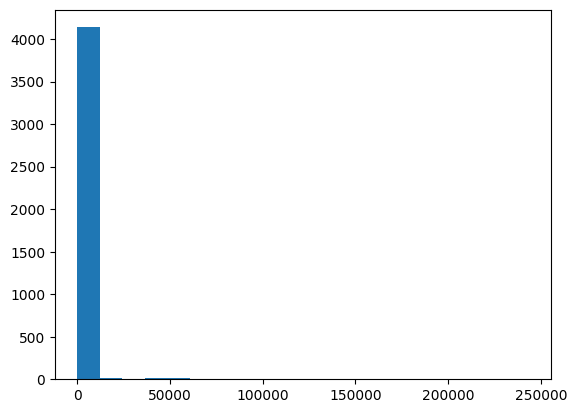

Duration histogram for 'W_Nabellen incomplete dossiers'


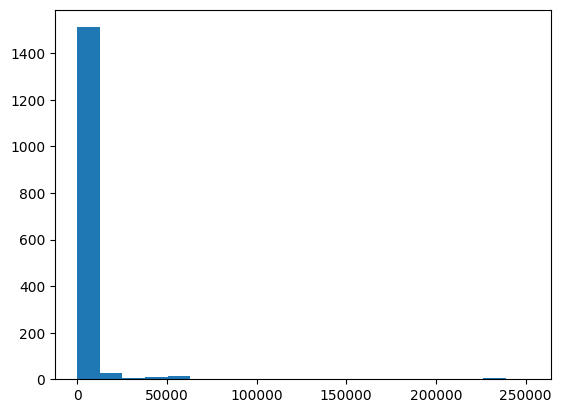

In [15]:
# investigate response times
response_times = {}
for trace in list_log_application:
    for e in trace:
        if "W_Nabellen" in e['concept:name']:
            if e['concept:name'] not in response_times:
                response_times[e['concept:name']] = []
            response_times[e['concept:name']].append(e['duration'])
print("Duration histogram for 'W_Nabellen offertes'")
plt.hist(response_times['W_Nabellen offertes'], 20)
plt.show()
print("Duration histogram for 'W_Nabellen incomplete dossiers'")
plt.hist(response_times['W_Nabellen incomplete dossiers'], 20)
plt.show()

In [16]:
# Cluster call events based on call durations by Bayesian-Gaussian mixture clustering
def get_bayesian_gaussian_mixture(components, times):
    duration_classifier = {}
    for t in times:
        if len(times[t])==1:
            g = mixture.BayesianGaussianMixture(n_components=1,covariance_type='full')
            g.fit(np.array([[times[t]], [times[t]]]).reshape(-1, 1))
            duration_classifier[t] = g
            continue
        
        g = mixture.BayesianGaussianMixture(n_components=components,covariance_type='full', random_state=42)
        g.fit(np.array(times[t]).reshape(-1,1))
        duration_classifier[t] = g
    return duration_classifier

def classify_log(log, predictor):
    log = copy.deepcopy(log)
    for trace in log:
        for pos in range(1,len(trace)):
            action = trace[pos]["concept:name"]
            if "W_Nabellen" not in action:
                continue
            assert("duration" in trace[pos])
            duration = trace[pos]["duration"]
            suffix = str(predictor[action].predict(np.array(duration).reshape(1,-1))[0])
            assert(int(suffix) in list(range(0,100)))
            trace[pos]["concept:name"] += "#"+suffix

    return log

for e in list_log_application[0]:
    print(e["concept:name"])
print("####")

predictor = get_bayesian_gaussian_mixture(CLUSTER_COMPONENTS, response_times)
list_log_application = classify_log(list_log_application, predictor)

for e in list_log_application[0]:
    print(e["concept:name"])

start
A_SUBMITTED
A_PREACCEPTED
A_ACCEPTED
A_FINALIZED
O_CREATED0
W_Nabellen offertes
O_SENT_BACK
A_APPROVED
positive
####
start
A_SUBMITTED
A_PREACCEPTED
A_ACCEPTED
A_FINALIZED
O_CREATED0
W_Nabellen offertes#0
O_SENT_BACK
A_APPROVED
positive


# Log Properties
We investigate certain log properties differentiating the BPIC'17 event log from BPIC'12.
It shows that not only the average number of calls but also the average number of generated offers were significantly changed.

In [17]:
# investigate avg. number of calls in trace
counts_positive = {"W_Nabellen incomplete" : 0, "W_Nabellen offertes":0}
pos_count = 0
for trace in list_log_application:
    if contains(trace, "positive") :
        pos_count += 1
        for e in trace:
            if "W_Nabellen incomplete" in e['concept:name']:
                counts_positive["W_Nabellen incomplete"] += 1
            if "W_Nabellen offertes" in e['concept:name']:
                counts_positive['W_Nabellen offertes'] += 1

counts_negative = {"W_Nabellen incomplete" : 0, "W_Nabellen offertes":0}
neg_count = 0
for trace in list_log_application:
    if contains(trace, "negative") :
        neg_count += 1
        for e in trace:
            if "W_Nabellen incomplete" in e['concept:name']:
                counts_negative["W_Nabellen incomplete"] += 1
            if "W_Nabellen offertes" in e['concept:name']:
                counts_negative['W_Nabellen offertes'] += 1

both = {"W_Nabellen incomplete" : 0, "W_Nabellen offertes":0}
for k in counts_positive:
    both[k] = (counts_negative[k] + counts_positive[k])/(neg_count+pos_count)

for k in counts_positive:
    counts_positive[k] /= pos_count
for k in counts_negative:
    counts_negative[k] /= neg_count


print("Average number of calls in successful journeys", counts_positive)
print("Average number of calls in unsuccessful journeys", counts_negative)
print("Average number of calls in all journeys", both)

Average number of calls in successful journeys {'W_Nabellen incomplete': 0.6282279608192342, 'W_Nabellen offertes': 1.0031166518254675}
Average number of calls in unsuccessful journeys {'W_Nabellen incomplete': 0.05949412183826149, 'W_Nabellen offertes': 0.7011043819023869}
Average number of calls in all journeys {'W_Nabellen incomplete': 0.3122897288739363, 'W_Nabellen offertes': 0.8353453394023352}


In [18]:
# Investigate the average number of created offers
counts_pos = []
counts_neg = []
for trace in list_log_application:
    count = 0
    if contains(trace, "positive") :
        for e in trace:
            if "O_CREATED" in e['concept:name']:
                count += 1
        counts_pos.append(count)
    if contains(trace, "negative") :
        for e in trace:
            if "O_CREATED" in e['concept:name']:
                count += 1
        counts_neg.append(count)
print("Average number of created offers in successful journeys", sum(counts_pos)/len(counts_pos))
print("Average number of created offers in unsuccessful journeys", sum(counts_neg)/len(counts_neg))

counts = []
for trace in list_log_application:
    count = 0
    for e in trace:
        if "O_CREATED" in e['concept:name']:
            count += 1
    counts.append(count)
print("Average number of created offers in all journeys", sum(counts)/len(counts))

Average number of created offers in successful journeys 1.4804096170970615
Average number of created offers in unsuccessful journeys 0.7759173494834343
Average number of created offers in all journeys 1.0890560063328716


In [19]:
# export the log for easier further analysis
def export(log, path):
    # to use the pm4py write_xes function, an pm4py event log object is needed.
    # for this is the list event log via the pandas data frame to a pm4py event log converted.
    log_df = pd.DataFrame()
    for trace in log:
        assert(trace[0]["concept:name"]=="start")
        assert(contains(trace, "negative") or contains(trace, "positive"))
        log_df = pd.concat([log_df, pd.DataFrame(trace)], ignore_index=True)
        #log_df = log_df.append(trace, ignore_index=True) # now deprecated

    log_df['time:timestamp'] = pd.to_datetime(log_df['time:timestamp'], utc = True)
    event_log = pm4py.convert_to_event_log(log_df)
    pm4py.write_xes(event_log, path) 

if SAVE_ELEMENTS:
    export(list_log_application, BPI_PATH_PROCESSED)

exporting log, completed traces :: 100%|██████████| 5053/5053 [00:01<00:00, 3180.26it/s]


In [20]:
import_log = xes_importer.apply(BPI_PATH_PROCESSED)

parsing log, completed traces :: 100%|██████████| 5053/5053 [00:01<00:00, 2733.43it/s]


In [21]:
for trace_index in range(len(import_log)):
    trace = import_log[trace_index]
    if trace[0]['concept:name']!="start":
        for e in trace:
            print(e['concept:name'])
    assert(trace[0]['concept:name']=="start")

# Process Model Construction
The process model is build with the published decision boundary tool.
We iterate over different settings to find the most promising one.
The final model uses the muli-set abstraction with a history of 5.

In [22]:
def compare(xes, activities, start = 3):
    r = []
    for type in ["multiset", "sequence"]:
        r.append("Abstraction "+ type)
        for hist in range(start,7):
            # use granular tool to build process models
            o = subprocess.check_output(["python3", "cli/process_model.py", xes, "cli/", "-t", type, "-hist" , str(hist)])
            f = str(o).replace("\\n'", '').split("Generated: ")[-1]
            o = subprocess.check_output(["python3", "cli/build_game.py", f, "cli/", activities])
            f = str(o).replace("\\n'", '').split("Generated: ")[-1]
            inner_graph = nx.read_gexf(f)
            r.append("History: "+ str(hist)+ " Loops: "+str(len(list(nx.simple_cycles(inner_graph)))) + " Nodes: " +str(len(inner_graph.nodes())))
    return r

for e in compare(BPI_PATH_PROCESSED, ACTIVITIES_PATH):
    print(e)

/home/paul/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
parsing log, completed traces :: 100%|██████████| 5053/5053 [00:01<00:00, 2754.11it/s]
/home/paul/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
parsing log, completed traces :: 100%|██████████| 5053/5053 [00:01<00:00, 2780.82it/s]
/home/paul/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
parsing log, completed traces :: 100%|██████████| 5053/5053 [00:02<00:00, 2468.90it/s]
/home/paul/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported 

Abstraction multiset
History: 3 Loops: 175666 Nodes: 177
History: 4 Loops: 51746 Nodes: 316
History: 5 Loops: 2 Nodes: 449
History: 6 Loops: 6 Nodes: 560
Abstraction sequence
History: 3 Loops: 3500 Nodes: 254
History: 4 Loops: 94 Nodes: 471
History: 5 Loops: 0 Nodes: 706
History: 6 Loops: 0 Nodes: 894


# Decision Boundary Analysis
The decision boundary of the process model with the multi-set abstraction and history of 5 is analysed.
In the accompanying paper we compare the properties of the BPIC'12 decision boundary with the ones from BPIC'17.

In [23]:
#  Build process model
output = subprocess.check_output(["python3", "cli/process_model.py", BPI_PATH_PROCESSED, "cli/", "-t", "multiset", "-hist" , "5"])
file_name = str(output).replace("\\n'", '').split("Generated: ")[-1]
print(file_name)
# Build user journey game
output = subprocess.check_output(["python3", "cli/build_game.py", file_name, "cli/", ACTIVITIES_PATH])
file_name = str(output).replace("\\n'", '').split("Generated: ")[-1]
print(file_name)
g = nx.read_gexf(file_name)
print('Nodes', len(g.nodes))

/home/paul/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
parsing log, completed traces :: 100%|██████████| 5053/5053 [00:01<00:00, 2701.47it/s]


cli/PMODEL_input:bpi2012_type:multiset_history:5.gexf
cli/GAME_input:bpi2012_type:multiset_history:5_actors:activities2012.xml.gexf
Nodes 449


In [24]:
def draw_dfg(g, name, layout = "sfdp"):
    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'cost')
    scaling = 10
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        #e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
        e.attr["label"] = edge_weights[e]
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"

    for s in g.nodes:
        if "decision_boundary" in g.nodes[s]:
            if g.nodes[s]["decision_boundary"]:
                g.nodes[s]['color'] = "blue"
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    print("Plotted", name)
    A.draw(name)

# plot process model for analysis
if SAVE_ELEMENTS:
    draw_dfg(g, "bpi2012.ps", "dot")

Plotted bpi2012.ps


In [25]:
# construct decision boundary
output = subprocess.check_output(["python3", "cli/decision_boundary.py", file_name, "cli/", VERIFYTA_PATH, "-q", "cli/guaranteed_tool.q"])
file_name = str(output).replace("\\n'", '').split("Generated: ")[-1]
print(file_name)

cli/DECB_input:bpi2012_type:multiset_history:5_actors:activities2012_unrolling_factor:0_.gexf


In [26]:
# apply reduction

output = subprocess.check_output(["python3", "cli/decision_boundary_reduction.py", file_name, "cli/"])
file_name = str(output).replace("\\n'", '').split("Generated: ")[-1]
print(file_name)
g_dec_boundary = nx.read_gexf(file_name)
print('Nodes after reduction', len(g_dec_boundary.nodes))

cli/DECB_input:bpi2012_type:multiset_history:5_actors:activities2012_unrolling_factor:0_reduced:True.gexf
Nodes after reduction 152


In [27]:
# function to retreive decision boundary states from 
def get_dec_bound(g):
    bound = []
    for s in g.nodes:
        if "decision_boundary" in g.nodes[s]:
            if g.nodes[s]["decision_boundary"]:
                bound.append(s)
                print(s)
    return bound

bound = get_dec_bound(g_dec_boundary)
print("States in decision boundary", len(bound))

{"A_FINALIZED": 1, "O_CREATED0": 1, "O_SENT_BACK": 1, "W_Nabellen incomplete dossiers#1": 1, "W_Nabellen offertes#0": 1}
{"O_CANCELLED": 2, "O_CREATED4": 1, "W_Nabellen offertes#0": 1, "W_Nabellen offertes#2": 1}
{"A_ACCEPTED": 1, "A_FINALIZED": 1, "O_CREATED0": 1, "O_SENT_BACK": 1, "W_Nabellen incomplete dossiers#1": 1}
{"O_CANCELLED": 1, "O_CREATED2": 1, "O_SENT_BACK": 1, "W_Nabellen incomplete dossiers#0": 1, "W_Nabellen incomplete dossiers#2": 1}
{"O_CANCELLED": 1, "O_CREATED2": 1, "O_SENT_BACK": 2, "W_Nabellen incomplete dossiers#2": 1}
{"O_CANCELLED": 2, "O_CREATED5": 1, "W_Nabellen incomplete dossiers#0": 2}
{"O_CANCELLED": 1, "O_CREATED3": 1, "O_SENT_BACK": 1, "W_Nabellen incomplete dossiers#2": 1, "W_Nabellen offertes#0": 1}
{"O_CANCELLED": 2, "O_CREATED4": 1, "W_Nabellen offertes#0": 2}
{"O_CANCELLED": 2, "O_CREATED4": 1, "O_SENT_BACK": 1, "W_Nabellen offertes#0": 1}
States in decision boundary 9


In [28]:
# bound contains no element with no call ("W_Nabellen")
for n in bound:
    if "W_Nabellen" not in n:
        print(n)

In [29]:
print("States with one cancellations")
for n in bound:
    if '"O_CANCELLED": 1' in n:
        print(n)
print()
print("States with two cancellations")
for n in bound:
    if '"O_CANCELLED": 2' in n:
        print(n)
print()
print("States with no cancellations")
for n in bound:
    if "O_CANCELLED" not in n:
        print(n)

States with one cancellations
{"O_CANCELLED": 1, "O_CREATED2": 1, "O_SENT_BACK": 1, "W_Nabellen incomplete dossiers#0": 1, "W_Nabellen incomplete dossiers#2": 1}
{"O_CANCELLED": 1, "O_CREATED2": 1, "O_SENT_BACK": 2, "W_Nabellen incomplete dossiers#2": 1}
{"O_CANCELLED": 1, "O_CREATED3": 1, "O_SENT_BACK": 1, "W_Nabellen incomplete dossiers#2": 1, "W_Nabellen offertes#0": 1}

States with two cancellations
{"O_CANCELLED": 2, "O_CREATED4": 1, "W_Nabellen offertes#0": 1, "W_Nabellen offertes#2": 1}
{"O_CANCELLED": 2, "O_CREATED5": 1, "W_Nabellen incomplete dossiers#0": 2}
{"O_CANCELLED": 2, "O_CREATED4": 1, "W_Nabellen offertes#0": 2}
{"O_CANCELLED": 2, "O_CREATED4": 1, "O_SENT_BACK": 1, "W_Nabellen offertes#0": 1}

States with no cancellations
{"A_FINALIZED": 1, "O_CREATED0": 1, "O_SENT_BACK": 1, "W_Nabellen incomplete dossiers#1": 1, "W_Nabellen offertes#0": 1}
{"A_ACCEPTED": 1, "A_FINALIZED": 1, "O_CREATED0": 1, "O_SENT_BACK": 1, "W_Nabellen incomplete dossiers#1": 1}


In [30]:
def to_set(bound):
    bounds = []
    for n in bound:
        b = {}
        n = n.replace("{","")
        n = n.replace("}","")
        n = n.replace('"',"")
        n = n.replace(' ',"")
        s = n.split(",")
        for e in s:
            s1 = e.split(":")
            b[s1[0]] = int(s1[-1])
        bounds.append(b)
    return bounds
bounds = to_set(bound)

In [31]:
def dist(s,t):
    not_contained = 0
    for k in s:
        if k not in t:
            not_contained += 1
        elif s[k] != t[k]:
            not_contained += abs(s[k]-t[k])
    return not_contained

def build_dec_bound_graph(bounds):
    g = nx.Graph()
    for s in bounds:
        g.add_node(str(s))
    for s in bounds:
        for t in bounds:
            if s == t:
                continue
            if dist(s,t) <= 1:
                g.add_edge(str(s),str(t))
    return g
g = build_dec_bound_graph(bounds)

In [32]:
# allows to plot the decision boundary as independent graph and analyse the cancellation clusters; requires that input models are in multi-set form
# (not part of publication)
def cluster_contains(c, s):
    for e in c:
        if s not in e:
            return False
    return True

def analyse_decision_boundary(file_name, name):
    g_dec_boundary = nx.read_gexf(file_name)
    bound = get_dec_bound(g_dec_boundary)
    bounds = to_set(bound)
    g = build_dec_bound_graph(bounds)

    A = to_agraph(g)

    count = 0
    for c in nx.connected_components(g):
        print(list(c)[0])
        print(len(c))

        label = "0" if not cluster_contains(c,"O_CANCELLED") else "1" if cluster_contains(c,"'O_CANCELLED': 1") else "2"
        
        if label == "0":
            assert(not cluster_contains(c,"'O_CANCELLED': 1"))
            assert(not cluster_contains(c,"'O_CANCELLED': 2"))

        if label == "1":
            assert(not cluster_contains(c,"'O_CANCELLED': 2"))

        if label == "2":
            assert(not cluster_contains(c,"'O_CANCELLED': 1"))

        colors = ["blue", "red", "orange"]
        A.add_subgraph(c, name='cluster_'+str(count), label= "#"+label, color = colors[int(label)], fontsize = 60, fontcolor = colors[int(label)])

        count+=1

    for n in A.nodes():
        n.attr['penwidth'] = 5
        n.attr["label"] = ""

    A.layout("dot")
    print("Plotted", name)
    A.draw(name)
    
    nx.draw(g, node_size=80)

In [33]:
# produces Figure 6 in the publication - reduced decision boundary plot
def draw_dfg_cluster(g, name, layout = "sfdp"):

    # color graph
    for s in g:
        outgoing_sum = 0
        if "color" in g.nodes[s]:
            if g.nodes[s]['color'] == "blue":
                    continue
        for n in g[s]:
            if "cost" in g[s][n]:
                outgoing_sum += g[s][n]["cost"]
        if outgoing_sum >= 16:
            g.nodes[s]['color'] = "#0ead69"
        elif outgoing_sum <= -30:
            g.nodes[s]['color'] = "#9a031e"
        else:
            g.nodes[s]['color'] = "grey"
            
    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'cost')
    scaling = 10

    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = "15"
        e.attr["fontsize"] = "20"
        e.attr["label"] = ""
        e.attr["color"] = "red" if edge_weights[e] < 0 else "green"
        if e[1] == 'neg':
            e.attr["color"] = "gray"
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"
            elif 'contraction' in g.edges[e]:
                for e_inner in g.edges[e]['contraction']:
                    if e_inner[0] == e[0]:
                        if not g.edges[e]['contraction'][e_inner]['controllable']:
                            edge = A.get_edge(e[0], e[1])
                            edge.attr["style"] = "dotted"
    clusters = {"0": [], "1": [], "2":[]}
    for s in A.nodes():
        if "decision_boundary" in s.attr:
            if s.attr["decision_boundary"] == "True":
                s.attr['color'] = "blue"
                
                c = "0" if not "O_CANCELLED" in s else "1" if '"O_CANCELLED": 1' in s else "2"
                clusters[c].append(s)

    count = 0
    
    A.add_edge("secret_start", '{"A_SUBMITTED": 1, "start": 1}') # add to draw start edge
    e = A.get_edge("secret_start", '{"A_SUBMITTED": 1, "start": 1}')
    e.attr["penwidth"] = "20"
    e.attr["fontsize"] = "50"
    e.attr["label"] = ""
    for n in A.nodes():
        n.attr['fontsize'] = 100
        n.attr['penwidth'] = 20
        n.attr['height'] = 2
        n.attr['width'] = 2
        if n == "pos":
            n.attr['color'] = "#0ead69"
            n.attr['fontcolor'] = "#0ead69"
            n.attr['label'] = 'Cpos'
        if n == "neg":
            n.attr['color'] = "#9a031e"
            n.attr['fontcolor'] = "#9a031e"
            n.attr['label'] = 'Cneg'
        
            
        if n not in ["pos", "neg"]:
            n.attr['label'] = ""
        if n == '{"A_SUBMITTED": 1, "start": 1}': # merged edges remove "start"
            n.attr['label'] = "s₀" #"s0"
        if n == "secret_start":
            n.attr['shape'] = "none"
    
    A.layout(layout)
    print("Plotted", name)
    A.draw(name)

def get_connection(g):
    for s in g:
        if len(list(g[s]))!= 1:
            continue
        assert(len(list(g[s]))==1)
        v = list(g[s])[0]

        edges = list(g.in_edges(v))
        if len(edges) == 1:
            s1 = edges[0][0]
            v1 = edges[0][1]
            assert(s == s1 and v == v1)
            return (s,v)
    return None

# Function to merge all 1:1 edges, produces a smaller plot
def merge_connections(g):
    g = copy.deepcopy(g)
    
    edge = get_connection(g)
    while(edge != None):
        g = nx.contracted_nodes(g, edge[1], edge[0])
        g.remove_edges_from(nx.selfloop_edges(g))
        edge = get_connection(g)
        
    return g

if SAVE_ELEMENTS:
    to_draw = nx.read_gexf(file_name)
    working_copy = copy.deepcopy(to_draw)
    working_copy = merge_connections(working_copy)
    print("Leaving positive", len(working_copy['pos']))
    for e in working_copy.out_edges("pos"):
        print(e[1], working_copy.edges[e])
    
    draw_dfg_cluster(working_copy, "clustered_2012.png", layout = "dot")


Leaving positive 2
{"O_CANCELLED": 2, "O_CREATED2": 1, "O_CREATED3": 1, "W_Nabellen incomplete dossiers#0": 1} {'action': 'O_CREATED3', 'cost': -2.57, 'edge_traversal': 3, 'controllable': True, 'id': '325'}
{"O_CANCELLED": 1, "O_CREATED2": 1, "O_SENT_BACK": 1, "W_Nabellen incomplete dossiers#1": 1, "W_Nabellen offertes#2": 1} {'action': 'O_CREATED2', 'cost': 15.8, 'edge_traversal': 1, 'controllable': True, 'id': '525'}
Plotted clustered_2012.png


In [34]:
[t for t in working_copy.nodes() if "start" in t]

['{"A_SUBMITTED": 1, "start": 1}',
 '{"A_PREACCEPTED": 1, "A_SUBMITTED": 1, "start": 1}',
 '{"A_ACCEPTED": 1, "A_PREACCEPTED": 1, "A_SUBMITTED": 1, "start": 1}']

# Dimension Reduction
We investigate the applicability of the decision boundary as dimension reduction technique.
When interpreting single events as features, many events are highly correlated.
For instance, when entering the positive or negative cluster the outcome is determined and many events are thus positively correlated.
When removing the events contained in the decision boundary, the present correlations reduce drastically.

In [35]:
# build strict db
# Build process model
output = subprocess.check_output(["python3", "cli/process_model.py", BPI_PATH_PROCESSED, "cli/", "-t", "multiset", "-hist" , "5"])
file_name = str(output).replace("\\n'", '').split("Generated: ")[-1]
# Build user journey game
output = subprocess.check_output(["python3", "cli/build_game.py", file_name, "cli/", ACTIVITIES_PATH])
file_name = str(output).replace("\\n'", '').split("Generated: ")[-1]
g = nx.read_gexf(file_name)
# construct decision boundary
output = subprocess.check_output(["python3", "cli/decision_boundary.py", file_name, "cli/", VERIFYTA_PATH, "-q", "cli/guaranteed_tool.q", "-s", "true"])
file_name = str(output).replace("\\n'", '').split("Generated: ")[-1]
# apply reduction
print(file_name)
output = subprocess.check_output(["python3", "cli/decision_boundary_reduction.py", file_name, "cli/", "-s", "true"])
file_name = str(output).replace("\\n'", '').split("Generated: ")[-1]

g_strict_dec_boundary = nx.read_gexf(file_name)

/home/paul/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
parsing log, completed traces :: 100%|██████████| 5053/5053 [00:01<00:00, 2742.12it/s]


cli/DECB_input:bpi2012_type:multiset_history:5_actors:activities2012_unrolling_factor:0_.gexf


In [36]:
def ms(trace):
    multiset = {}
    for pos in trace:
        if pos['concept:name'] not in multiset:
            multiset[pos['concept:name']] = 1
        else:
            multiset[pos['concept:name']] += 1
    return json.dumps(multiset, sort_keys=True).encode().decode("utf-8") # use json encodings for multisets

def hist(trace): 
    hist = str(trace[0]['concept:name'])
    for pos in trace[1:]:
        hist += " - " + str(pos['concept:name']) # construct history
    return hist

def to_df(log, file_name, abstraction_history):
    system = nx.read_gexf(file_name)
    #trace_df = pd.DataFrame(columns = list(system.edges()).append("y"))

    columns = list(set([system.edges[e]['action'] for e in system.edges()]))#list(system.edges())
    columns.append("start")
    trace_df = pd.DataFrame(columns = columns)#list(system.edges()).append('y'))

    data_list = []
    for trace in log:
        trace_edges = [x['concept:name'] for x in trace]
        data = {"start":1}
        s = "start"
        assert(trace[0]['concept:name']=="start")
        for i in range(1,len(trace_edges)):
            t = ms(trace[max(0,i-abstraction_history+1):i+1])
            current = trace_edges[i]
            if t not in list(system.nodes()):
                s = t
                continue
            if current not in data:
                data[current] = 1
            #else:
            #    data[(s,t)] = data[(s,t)]+1
            s = t
        data["y"] = 1 if "positive" in trace_edges else -1
        data_list.append(data)
    trace_df = pd.DataFrame(data_list)
    # trace_df = trace_df.append(data, ignore_index=True)
    trace_df = trace_df.fillna(0)
    assert(len(trace_df.index) == len(log))
    return trace_df

def to_df(log, file_name, abstraction, history, limit = 0):
    system = nx.read_gexf(file_name)
    columns = set()
    for trace in log:
        columns.update(set([t['concept:name'] for t in trace]))
    #columns = list(set([system.edges[e]['action'] for e in system.edges()]))#list(system.edges())
    assert("start" in columns)
    columns = list(columns)
    trace_df = pd.DataFrame(columns = columns)#list(system.edges()).append('y'))
    data_list = []
    for trace in log:
        trace_edges = [x['concept:name'] for x in trace]
        data = {"start":1}
        assert(trace[0]['concept:name']=="start")
        for i in range(1,len(trace_edges)-limit):
            t = abstraction(trace[max(0,i-history+1):i+1])
            current = trace_edges[i]
            if t not in list(system.nodes()):
                continue
            if current not in data:
                data[current] = 1
        # ensure that every feature in contained
        for d in data:
            if d not in trace_df.columns:
                print(d)
            assert d in trace_df.columns
        # ensure all fields are present
        for column in columns:
            if column not in data:
                data[column] = 0
        # append to dataframe
        # trace_df = pd.concat([trace_df, pd.DataFrame(data, index = [0])], ignore_index=True)
        data_list.append(data)
    trace_df = pd.DataFrame(data_list) #pd.concat([trace_df, pd.DataFrame(data_list)], ignore_index=True) # update from concat solution
    trace_df = trace_df.fillna(0)
    assert len(trace_df.index) == len(log)
    assert len(trace_df.columns) == len(columns), f'Columns df:{trace_df.columns} (len({len(trace_df.columns)})), columns: {columns} len({len(columns)})'
    return trace_df

# analyse used process model with mutli-set abstraction and history 5
trace_df = to_df(list_log_application,"cli/DECB_input:bpi2012_type:multiset_history:5_actors:activities2012_unrolling_factor:0_.gexf" ,ms, 5)
trace_df_reduced = to_df(list_log_application,"cli/DECB_input:bpi2012_type:multiset_history:5_actors:activities2012_unrolling_factor:0_reduced:True.gexf" , ms, 5)
correlations = trace_df.corr().unstack().to_dict()

In [37]:
print(trace_df.columns)
print(trace_df_reduced.columns)
for c in trace_df.columns:
    if((trace_df[c] == 0).all()):
        print("not contained", c)
print()
for c in trace_df_reduced.columns:
    if((trace_df_reduced[c] == 0).all()):
        print("removed", c)

print('A_CANCELLED' in trace_df_reduced.columns)
print('O_CREATED6' in trace_df_reduced.columns)
print('A_APPROVED' in trace_df_reduced.columns)

Index(['start', 'A_SUBMITTED', 'A_PREACCEPTED', 'A_ACCEPTED', 'A_FINALIZED',
       'O_CREATED0', 'W_Nabellen offertes#0', 'O_SENT_BACK', 'A_APPROVED',
       'positive', 'O_CREATED6', 'negative', 'O_CREATED4',
       'W_Nabellen offertes#1', 'O_CREATED1', 'W_Nabellen offertes#2',
       'O_CREATED3', 'W_Nabellen incomplete dossiers#1',
       'W_Nabellen incomplete dossiers#2', 'O_CANCELLED', 'O_CREATED5',
       'A_CANCELLED', 'O_CREATED2', 'W_Nabellen incomplete dossiers#0'],
      dtype='object')
Index(['start', 'A_SUBMITTED', 'A_PREACCEPTED', 'A_ACCEPTED', 'A_FINALIZED',
       'O_CREATED0', 'W_Nabellen offertes#0', 'O_SENT_BACK', 'O_CREATED6',
       'negative', 'A_APPROVED', 'O_CREATED4', 'W_Nabellen offertes#1',
       'O_CREATED1', 'W_Nabellen offertes#2', 'O_CREATED3',
       'W_Nabellen incomplete dossiers#1', 'W_Nabellen incomplete dossiers#2',
       'O_CANCELLED', 'O_CREATED5', 'positive', 'A_CANCELLED', 'O_CREATED2',
       'W_Nabellen incomplete dossiers#0'],
      dtyp

In [38]:
trace_df

,start,A_SUBMITTED,A_PREACCEPTED,A_ACCEPTED,A_FINALIZED,O_CREATED0,W_Nabellen offertes#0,O_SENT_BACK,A_APPROVED,positive,...,O_CREATED1,W_Nabellen offertes#2,O_CREATED3,W_Nabellen incomplete dossiers#1,W_Nabellen incomplete dossiers#2,O_CANCELLED,O_CREATED5,A_CANCELLED,O_CREATED2,W_Nabellen incomplete dossiers#0
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,0,0,1,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5048,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5049,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5050,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5051,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


start                               5053
A_SUBMITTED                         5053
A_PREACCEPTED                       5052
A_ACCEPTED                          3952
A_FINALIZED                         3886
O_CREATED0                          3886
W_Nabellen offertes#0               3141
O_SENT_BACK                         2404
A_APPROVED                          2246
positive                            2246
O_CREATED6                             3
negative                            2807
O_CREATED4                            38
W_Nabellen offertes#1                 91
O_CREATED1                          1126
W_Nabellen offertes#2                252
O_CREATED3                            92
W_Nabellen incomplete dossiers#1      48
W_Nabellen incomplete dossiers#2     192
O_CANCELLED                         2348
O_CREATED5                            10
A_CANCELLED                         2807
O_CREATED2                           348
W_Nabellen incomplete dossiers#0    1150
dtype: int64

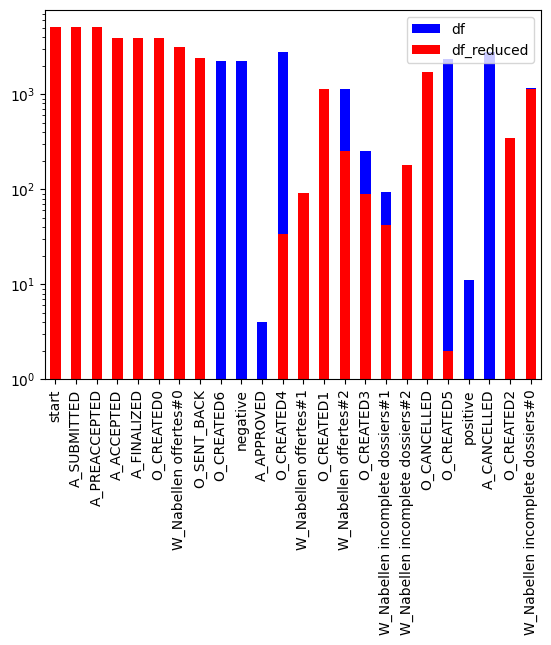

In [39]:
trace_df.sum().plot(kind="bar", log=True, color="blue", label="df")
trace_df_reduced.sum().plot(kind="bar", log=True, color="red", label="df_reduced")
plt.legend()
trace_df.sum()

/tmp/ipykernel_9165/498526035.py:16: RuntimeWarning: invalid value encountered in scalar divide
  print("Remaining correlations in % after reduction", [counts1[i]/counts[i] for i in range(len(counts))])


Remaining correlations in % after reduction [0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, 0.125, 0.6, 0.6666666666666666, 0.7407407407407407, 0.7222222222222222, 2.0, 0.2857142857142857, 0.35714285714285715, 1.0, 1.5, nan, 0.6388888888888888]


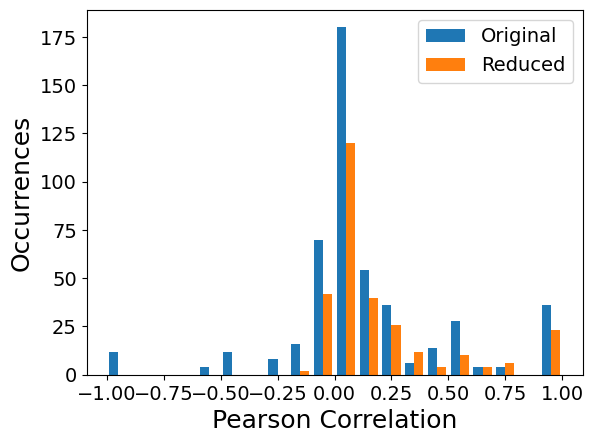

[ 12.   0.   0.   0.   4.  12.   0.   8.  16.  70. 180.  54.  36.   6.
  14.  28.   4.   4.   0.  36.] [  0.   0.   0.   0.   0.   0.   0.   0.   2.  42. 120.  40.  26.  12.
   4.  10.   4.   6.   0.  23.]
0.0
nan
nan
nan
0.0
0.0
nan
0.0
0.125
0.6
0.6666666666666666
0.7407407407407407
0.7222222222222222
2.0
0.2857142857142857
0.35714285714285715
1.0
1.5
nan
0.6388888888888888


/tmp/ipykernel_9165/498526035.py:30: RuntimeWarning: invalid value encountered in scalar divide
  print(counts1[i]/counts[i])


In [40]:
# construct comparison plot
#counts, bins, bars = plt.hist([x for x in trace_df.corr().unstack() if abs(x) > -0.2], 20, label = "Original", color = '#377eb8')#'#0C7BDC')
#counts1, bins1, bars1 = plt.hist([x for x in trace_df_reduced.corr().unstack() if abs(x) > -0.2], 20, label = "Reduced", range = [-1,1], color = '#ff7f00')#'#FFC20A')
#plt.show()

x = [x for x in trace_df.corr().unstack() if abs(x) > -0.2]
y = [x for x in trace_df_reduced.corr().unstack() if abs(x) > -0.2]
c, bins, bars = plt.hist([x, y], 20, label=['Original', 'Reduced'])
counts = c[0]
counts1 = c[1]

#plt.hist([x for x in trace_df.corr().unstack() if abs(x) > -0.2], 20, color=[1,0,0,0], edgecolor='blue', linestyle="--")

#plt.bar(0.8,100, 0.1, align = "edge", color=[1,0,0,0], edgecolor='blue', linestyle="--")

print("Remaining correlations in % after reduction", [counts1[i]/counts[i] for i in range(len(counts))])

plt.xlabel("Pearson Correlation", fontsize = 18)
plt.ylabel("Occurrences", fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplots_adjust(bottom=0.12)
plt.legend(prop={'size':14})
if SAVE_ELEMENTS:
    plt.savefig("2012_correlations.png", dpi = 300)
plt.show()

print(counts, counts1)
for i in range(len(counts)):
    print(counts1[i]/counts[i])

# Tree predictor

In [41]:
from sklearn import tree

In [42]:
trace_df.columns

Index(['start', 'A_SUBMITTED', 'A_PREACCEPTED', 'A_ACCEPTED', 'A_FINALIZED',
       'O_CREATED0', 'W_Nabellen offertes#0', 'O_SENT_BACK', 'A_APPROVED',
       'positive', 'O_CREATED6', 'negative', 'O_CREATED4',
       'W_Nabellen offertes#1', 'O_CREATED1', 'W_Nabellen offertes#2',
       'O_CREATED3', 'W_Nabellen incomplete dossiers#1',
       'W_Nabellen incomplete dossiers#2', 'O_CANCELLED', 'O_CREATED5',
       'A_CANCELLED', 'O_CREATED2', 'W_Nabellen incomplete dossiers#0'],
      dtype='object')

In [43]:
Y = trace_df['positive']
X = trace_df.drop(['positive', 'negative'], axis=1)

In [44]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

[Text(0.5, 0.75, 'x[19] <= 0.5\ngini = 0.494\nsamples = 5053\nvalue = [2807, 2246]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 2246\nvalue = [0, 2246]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 2807\nvalue = [2807, 0]')]

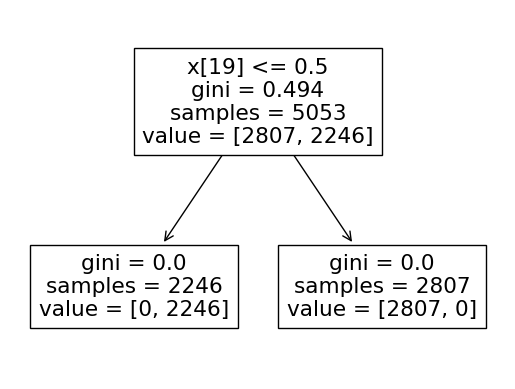

In [45]:
tree.plot_tree(clf)

In [46]:
print(X.columns[2])

A_PREACCEPTED


In [47]:
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus

In [48]:
def print_accuracy(pred):
    print(f"Accuracy = {100 * np.sum(pred == Y) / len(Y)}%")

df_one_hot = to_df(list_log_application,"cli/DECB_input:bpi2012_type:multiset_history:5_actors:activities2012_unrolling_factor:0_.gexf" ,ms, 5, limit=0)
Y = df_one_hot['positive'] - df_one_hot['negative']

def build_all_trees(original = False):
    for limit in range(0, 20):
        if original:
            df_one_hot = to_df(list_log_application,"cli/DECB_input:bpi2012_type:multiset_history:5_actors:activities2012_unrolling_factor:0_.gexf" ,ms, 5, limit=limit)
        else:
            df_one_hot = to_df(list_log_application,"cli/DECB_input:bpi2012_type:multiset_history:5_actors:activities2012_unrolling_factor:0_reduced:True.gexf" , ms, 5, limit = limit)
        
        print('##############', limit, '#####################')
        
        # Y = df_one_hot['positive']
        X = df_one_hot
        assert len(X) == len(Y), f'{len(X)} does not match {len(Y)}'
        if 'positive' in X.columns:
            X = df_one_hot.drop(['positive'], axis=1)
        if 'negative' in X.columns:
            X = df_one_hot.drop(['negative'], axis=1)
        
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(X, Y)
        
        removed_columns = ['A_APPROVED','O_CREATED6', 'A_CANCELLED', 'negative', 'positive']
        X_columns = [e if e not in removed_columns else 'REMOVED' for e in X.columns]
        
        n_nodes = clf.tree_.node_count
        feature = clf.tree_.feature
        children_left = clf.tree_.children_left
        children_right = clf.tree_.children_right
        split_counter = 0
        removed_counter = 0
        for i in range(n_nodes):
            if children_left[i] != children_right[i]: # ensure is split node
                split_counter += 1
                if X_columns[feature[i]] =='REMOVED':
                    removed_counter += 1
        print(f'used {removed_counter}/{split_counter} removed features')
        print_accuracy(clf.predict(X))
        
        # tree.plot_tree(clf, feature_names=X_columns)
        # plt.show()
        
        dot_data = export_graphviz(clf,
                            feature_names=X_columns,
                            out_file=None,
                            filled=True,
                            rounded=True)
        
        pydot_graph = pydotplus.graph_from_dot_data(dot_data)
        pydot_graph.write_pdf(f'tree_{limit}.pdf')
        

In [49]:
build_all_trees(True)

############## 0 #####################
used 1/1 removed features
Accuracy = 100.0%
############## 1 #####################
used 1/1 removed features
Accuracy = 100.0%
############## 2 #####################
used 2/43 removed features
Accuracy = 99.4062932911142%
############## 3 #####################
used 1/73 removed features
Accuracy = 82.60439342964575%
############## 4 #####################
used 0/70 removed features
Accuracy = 77.8745299821888%
############## 5 #####################
used 0/58 removed features
Accuracy = 78.25054423114982%
############## 6 #####################
used 0/56 removed features
Accuracy = 78.0922224421136%
############## 7 #####################
used 0/46 removed features
Accuracy = 77.3599841678211%
############## 8 #####################
used 0/35 removed features
Accuracy = 73.1842469819909%
############## 9 #####################
used 0/32 removed features
Accuracy = 73.14466653473184%
############## 10 #####################
used 0/24 removed features
Accu

In [50]:
build_all_trees(False)

############## 0 #####################
used 0/62 removed features
Accuracy = 97.56580249356817%
############## 1 #####################
used 0/62 removed features
Accuracy = 97.56580249356817%
############## 2 #####################
used 0/62 removed features
Accuracy = 97.56580249356817%
############## 3 #####################
used 0/63 removed features
Accuracy = 82.50544231149811%
############## 4 #####################
used 0/69 removed features
Accuracy = 77.83494953492975%
############## 5 #####################
used 0/56 removed features
Accuracy = 78.25054423114982%
############## 6 #####################
used 0/56 removed features
Accuracy = 78.11201266574312%
############## 7 #####################
used 0/45 removed features
Accuracy = 77.3599841678211%
############## 8 #####################
used 0/35 removed features
Accuracy = 73.1842469819909%
############## 9 #####################
used 0/32 removed features
Accuracy = 73.14466653473184%
############## 10 #####################
us

In [51]:
import shap
shap.plots.initjs()

In [52]:
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X, Y)
print_accuracy(clf.predict(X))

sub_data = shap.sample(X, 400)
explainer = shap.TreeExplainer(clf.predict_proba, sub_data) # KernelExplainer
shap_values = shap.Explainer(clf)#.shap_values(sub_data)
# shap.force_plot(explainer.expected_value[0], shap_values[..., 0], sub_data)
# shap.plots.violin(shap_values[:,:,1], features=sub_data, plot_type="layered_violin")
print(isinstance(shap_values, shap.Explanation))
print(type(shap_values))
shap.plots.beeswarm(shap_values)
# shap.summary_plot(
#     shap_values[:1000, :],
#     X.iloc[:1000, :],
#     plot_type="layered_violin",
#     color="coolwarm",
# )


# shap.summary_plot(shap_values[:, :], X.iloc[:, :])

Accuracy = 44.44884227191767%


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'method'>

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<class 'pandas.core.frame.DataFrame'>


100%|██████████| 500/500 [02:24<00:00,  3.47it/s]


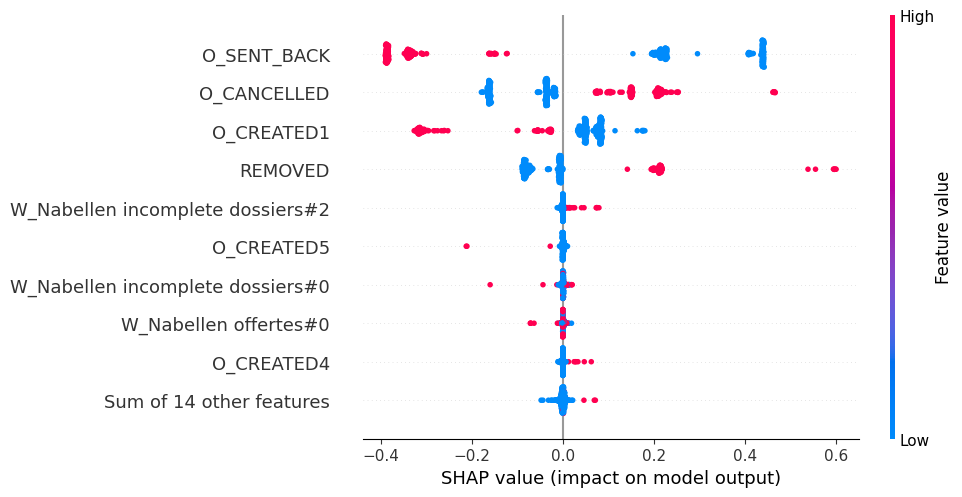

In [ ]:
removed_columns = ['A_APPROVED','O_CREATED6', 'A_CANCELLED', 'negative', 'positive']

df_one_hot = to_df(list_log_application,"cli/DECB_input:bpi2012_type:multiset_history:5_actors:activities2012_unrolling_factor:0_.gexf" ,ms, 5, limit=0)
Y = df_one_hot['positive'] - df_one_hot['negative']

if True:
    df_one_hot = to_df(list_log_application,"cli/DECB_input:bpi2012_type:multiset_history:5_actors:activities2012_unrolling_factor:0_.gexf" ,ms, 5, limit=2)
else:
    df_one_hot = to_df(list_log_application,"cli/DECB_input:bpi2012_type:multiset_history:5_actors:activities2012_unrolling_factor:0_reduced:True.gexf" , ms, 5, limit = limit)

X = df_one_hot
assert len(X) == len(Y), f'{len(X)} does not match {len(Y)}'
if 'positive' in X.columns:
    X = df_one_hot.drop(['positive'], axis=1)
if 'negative' in X.columns:
    X = df_one_hot.drop(['negative'], axis=1)
            
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

sub_data = shap.sample(X, 500)
print(type(sub_data))
sub_data.rename(columns={r : 'REMOVED' if r in removed_columns else r for r in list(sub_data.columns)}, inplace=True)
explainer = shap.KernelExplainer(clf.predict_proba, data=sub_data, feature_names=['t'])# KernelExplainer
# shap_values = explainer.shap_values(sub_data)
shap_obj = explainer(sub_data)[:,:,0]
ax = shap.plots.beeswarm(shap_obj, show=False)